# Bitcoin Analysis rev2

### Modules used in this assignment

In [14]:
from sklearn.ensemble import GradientBoostingClassifier as GB
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import AdaBoostClassifier as AB
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.neural_network import MLPClassifier as NN
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut as LOO
from sklearn.model_selection import KFold as KF
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler  
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

### Dataset

In [15]:
# which dataset?
"""to_test = 'bitcoin-day'

# dataset selection
nm = ['bitcoin-day','bitcoin-min']
opt = nm.index(to_test)
# format:  ['filepath','num_features','attribute_to_predict']
options = [['cryptocurrencypricehistory/bitcoin_dataset.csv',27,'price_increases'],['bitcoin-historical-data/btc-30min.csv',8,'price_increases_30']]
"""

# filename
f = 'data/ripple_price.csv'
# features available
num_feats = 16
# prediction attribute
attribute = 'increase_flag'

# load file
data = pd.read_csv(f)
# features
names = list(data.columns.values)

# label encoding
# if opt == 1:
#     data = data.apply(LabelEncoder().fit_transform)

# split targets from attributes
X = data.iloc[:,1:num_feats]
Y = data[attribute]

### Feature Selection

First, we use a model _not_ being evaluated in this assigment to visualize feature importance.

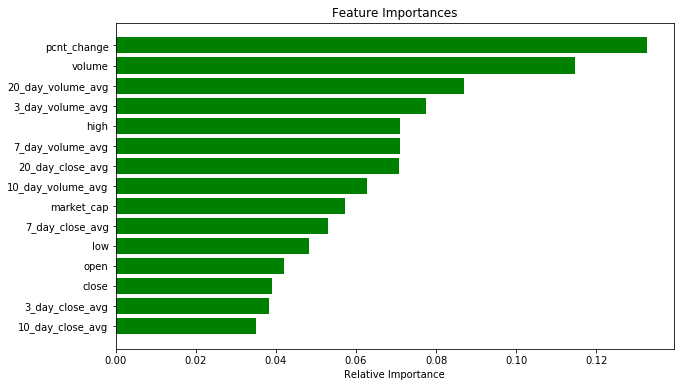

In [16]:
'''
# Principal Component Analysis
pca = PCA(n_components=26)
pca.fit(X)
print(pca.explained_variance_ratio_) 
X = pca.transform(X)
'''

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    random_state=42)

estimator = GB(n_estimators=200, learning_rate=0.01, max_depth=8, random_state=5)
#estimator = kNN(n_neighbors=7)
estimator.fit(X_train, Y_train)
# plot feature importance
features = data.columns[1:num_feats]
importances = estimator.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], 
         color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

Next, we use recursive feature elimination to reduce the number of attributes from 12 to 3.  We transform X, the input attributes, to reflect this choice.

In [19]:
estimator = GB(n_estimators=200, learning_rate=0.01, 
               max_depth=8, random_state=5)
selector = RFE(estimator, 9, step=1) # recursive feature elimination
selector = selector.fit(X_train, Y_train)
print(selector.ranking_) # value at [i] represents the importance of the given feature
X_reduced = selector.transform(X) # truncate the feature set

[5 4 1 6 1 2 1 1 1 1 1 1 3 7 1]


In [20]:
# returns indices of array elements matching a specified value
def find(lst, val):
    return [i for i, x in enumerate(lst) if x==val]
feats_idx = find(list(selector.ranking_),1) # indices of top features
selected_feats = features[feats_idx]
print("Selected Features:")
print(list(selected_feats))

Selected Features:
['low', 'volume', 'pcnt_change', '3_day_volume_avg', '7_day_volume_avg', '10_day_volume_avg', '20_day_volume_avg', '3_day_close_avg', '20_day_close_avg']


### Random Forest

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, np.array(Y), test_size=0.25, random_state=42)

print("\nFold\tOptimMaxDepth\tMCC\tAccuracy\n----\t-------------\t---\t--------")
fold = 0
kf1 = KF(n_splits=5)
rf_test_scores = []
rf_val_scores = []
matt_coeffs = []
max_depths = []

#X_rf = X
#X_rf = np.array(X_rf)
#Y_rf = np.array(Y)

# first resampling
for train_index, test_index in kf1.split(X_train):
    
    fold += 1
    xtrain, xtest = X_train[train_index], X_train[test_index]
    ytrain, ytest = Y_train[train_index], Y_train[test_index]
    kf2 = KF(n_splits=5)
    mult = 3
    innerfold = 0
    val_scores = []
    params = []
    
    # second resampling
    for train_idx, test_idx in kf2.split(xtrain):
        innerfold += 1
        xxtrain, xxval = xtrain[train_idx], xtrain[test_idx]
        yytrain, yyval = ytrain[train_idx], ytrain[test_idx]
        # model
        forest = RF(n_jobs=4,n_estimators=40,max_depth=innerfold*mult,class_weight='balanced')
        forest.fit(xxtrain, yytrain)
        # validation accuracy
        val_score = forest.score(xxval, yyval)
        val_scores.append(val_score)
        rf_val_scores.append(val_score)
        # save parameter of this round
        params.append(int(innerfold*mult))
    
    # pick model with best validation score and fit it to training data
    best_model_idx = val_scores.index(max(val_scores))
    max_depth = params[best_model_idx]
    max_depths.append(max_depth)
    forest = RF(n_jobs=4,n_estimators=20,max_depth=max_depth,class_weight='balanced')
    forest.fit(xtrain, ytrain)
    
    # test accuracy for this fold
    preds = forest.predict(xtest)
    test_score = forest.score(xtest, ytest)
    rf_test_scores.append(test_score)
    coeff = mcc(ytest, preds)
    matt_coeffs.append(coeff)
    print("%d\t%d\t\t%.3f\t%.2f" % (fold,max_depth,coeff,test_score*100))

# results of each testing phase
print("\nAverage test accuracy = %.2f%%" % (np.mean(rf_test_scores) * 100))
print("Average MCC = %.3f" % np.mean(matt_coeffs))
print("Average OptimMaxDepth = %d" % np.mean(max_depths))

# outermost test set
forest = RF(n_jobs=4,n_estimators=20,max_depth=int(np.mean(max_depths)),class_weight='balanced')
forest.fit(X_train,Y_train)
preds = forest.predict(X_test)
# confusion matrix
print("Confusion Matrix")
print(confusion_matrix(Y_test, preds))


Fold	OptimMaxDepth	MCC	Accuracy
----	-------------	---	--------
1	3		0.091	55.07
2	15		0.081	55.56
3	9		0.088	54.85
4	15		-0.050	48.54
5	3		0.082	54.85

Average test accuracy = 53.78%
Average MCC = 0.058
Average OptimMaxDepth = 9
Confusion Matrix
[[119  66]
 [ 84  75]]


### Adaboost

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, np.array(Y), test_size=0.25, random_state=24)

print("\nFold\t# Estimators\tMCC\tAccuracy\n----\t------------\t---\t--------")
fold = 0
kf1 = KF(n_splits=5)
ab_test_scores = []
ab_val_scores = []
matt_coeffs = []
max_depths = []

#X_rf = X
#X_rf = np.array(X_rf)
#Y_rf = np.array(Y)

# first resampling
for train_index, test_index in kf1.split(X_train):
    
    fold += 1
    xtrain, xtest = X_train[train_index], X_train[test_index]
    ytrain, ytest = Y_train[train_index], Y_train[test_index]
    kf2 = KF(n_splits=5)
    mult = 10
    innerfold = 0
    val_scores = []
    params = []
    
    # second resampling
    for train_idx, test_idx in kf2.split(xtrain):
        innerfold += 1
        xxtrain, xxval = xtrain[train_idx], xtrain[test_idx]
        yytrain, yyval = ytrain[train_idx], ytrain[test_idx]
        # model
        model = AB(n_estimators=10*mult*innerfold)
        model.fit(xxtrain, yytrain)
        # validation accuracy
        val_score = model.score(xxval, yyval)
        val_scores.append(val_score)
        ab_val_scores.append(val_score)
        # save parameter of this round
        params.append(int(10*innerfold*mult))
    
    # pick model with best validation score and fit it to training data
    best_model_idx = val_scores.index(max(val_scores))
    max_depth = params[best_model_idx]
    max_depths.append(max_depth)
    model = AB(n_estimators=max_depth)
    model.fit(xtrain, ytrain)
    
    # test accuracy for this fold
    preds = model.predict(xtest)
    test_score = model.score(xtest, ytest)
    ab_test_scores.append(test_score)
    coeff = mcc(ytest, preds)
    matt_coeffs.append(coeff)
    print("%d\t%d\t\t%.3f\t%.2f" % (fold,max_depth,coeff,test_score*100))

# results of each testing phase
print("\nAverage test accuracy = %.2f%%" % (np.mean(ab_test_scores) * 100))
print("Average MCC = %.3f" % np.mean(matt_coeffs))
print("Average Optim. # Estimators = %d" % np.mean(max_depths))

# outermost test set
model = AB(n_estimators=int(np.mean(max_depths)))
model.fit(X_train,Y_train)
preds = model.predict(X_test)
# confusion matrix
print("Confusion Matrix")
print(confusion_matrix(Y_test, preds))


Fold	# Estimators	MCC	Accuracy
----	------------	---	--------
1	100		-0.009	50.72
2	500		0.152	58.45
3	100		0.072	55.34
4	100		0.072	55.34
5	100		0.134	57.28

Average test accuracy = 55.43%
Average MCC = 0.084
Average Optim. # Estimators = 180
Confusion Matrix
[[134  61]
 [101  48]]


### Decision Tree

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, np.array(Y), test_size=0.25, random_state=16)

print("\nFold\tOptimMaxDepth\tMCC\tAccuracy\n----\t-------------\t---\t--------")
fold = 0
kf1 = KF(n_splits=5)
dt_test_scores = []
dt_val_scores = []
matt_coeffs = []
max_depths = []

#X_rf = X
#X_rf = np.array(X_rf)
#Y_rf = np.array(Y)

# first resampling
for train_index, test_index in kf1.split(X_train):
    
    fold += 1
    xtrain, xtest = X_train[train_index], X_train[test_index]
    ytrain, ytest = Y_train[train_index], Y_train[test_index]
    kf2 = KF(n_splits=5)
    mult = 4
    innerfold = 0
    val_scores = []
    params = []
    
    # second resampling
    for train_idx, test_idx in kf2.split(xtrain):
        innerfold += 1
        xxtrain, xxval = xtrain[train_idx], xtrain[test_idx]
        yytrain, yyval = ytrain[train_idx], ytrain[test_idx]
        # model
        model = DT(max_depth=mult*innerfold,criterion='entropy')
        model.fit(xxtrain, yytrain)
        # validation accuracy
        val_score = model.score(xxval, yyval)
        val_scores.append(val_score)
        dt_val_scores.append(val_score)
        # save parameter of this round
        params.append(int(innerfold*mult))
    
    # pick model with best validation score and fit it to training data
    best_model_idx = val_scores.index(max(val_scores))
    max_depth = params[best_model_idx]
    max_depths.append(max_depth)
    model = DT(max_depth=max_depth,criterion='entropy')
    model.fit(xtrain, ytrain)
    
    # test accuracy for this fold
    preds = model.predict(xtest)
    test_score = model.score(xtest, ytest)
    dt_test_scores.append(test_score)
    coeff = mcc(ytest, preds)
    matt_coeffs.append(coeff)
    print("%d\t%d\t\t%.3f\t%.2f" % (fold,max_depth,coeff,test_score*100))

# results of each testing phase
print("\nAverage test accuracy = %.2f%%" % (np.mean(dt_test_scores) * 100))
print("Average MCC = %.3f" % np.mean(matt_coeffs))
print("Average OptimMaxDepth = %d" % np.mean(max_depths))

# outermost test set
model = DT(max_depth=int(np.mean(max_depths)))
model.fit(X_train,Y_train)
preds = model.predict(X_test)
# confusion matrix
print("Confusion Matrix")
print(confusion_matrix(Y_test, preds))


Fold	OptimMaxDepth	MCC	Accuracy
----	-------------	---	--------
1	8		0.046	55.07
2	8		-0.093	45.41
3	8		0.042	58.25
4	12		-0.032	47.57
5	4		-0.034	57.28

Average test accuracy = 52.72%
Average MCC = -0.014
Average OptimMaxDepth = 8
Confusion Matrix
[[163  27]
 [125  29]]


### MLP

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, np.array(Y), test_size=0.25, random_state=99)

print("\nFold\tOptimal C\tMCC\tAccuracy\n----\t---------\t---\t--------")
fold = 0
kf1 = KF(n_splits=5)
svm_test_scores = []
svm_val_scores = []
matt_coeffs = []
max_depths = []

#X_rf = X
#X_rf = np.array(X_rf)
#Y_rf = np.array(Y)

# first resampling
for train_index, test_index in kf1.split(X_train):
    
    fold += 1
    xtrain, xtest = X_train[train_index], X_train[test_index]
    ytrain, ytest = Y_train[train_index], Y_train[test_index]
    kf2 = KF(n_splits=5)
    mult = 20
    innerfold = 0
    val_scores = []
    params = []
    
    # second resampling
    for train_idx, test_idx in kf2.split(xtrain):
        innerfold += 1
        xxtrain, xxval = xtrain[train_idx], xtrain[test_idx]
        yytrain, yyval = ytrain[train_idx], ytrain[test_idx]
        # transformations
        scaler = StandardScaler()  
        scaler.fit(xxtrain)  
        xxtrain = scaler.transform(xxtrain)  
        xxval = scaler.transform(xxval)
        # model
        model = NN(solver='lbfgs',hidden_layer_sizes=(10*innerfold*mult,5))
        model.fit(xxtrain, yytrain)
        # validation accuracy
        val_score = model.score(xxval, yyval)
        val_scores.append(val_score)
        svm_val_scores.append(val_score)
        # save parameter of this round
        params.append((10*innerfold*mult,5))
    
    # pick model with best validation score and fit it to training data
    best_model_idx = val_scores.index(max(val_scores))
    max_depth = params[best_model_idx]
    max_depths.append(max_depth)
    model = NN(solver='lbfgs',hidden_layer_sizes=max_depth)
    # transformations
    scaler = StandardScaler()  
    scaler.fit(xxtrain)  
    xtrain = scaler.transform(xtrain)  
    xtest = scaler.transform(xtest)
    model.fit(xtrain, ytrain)
    
    # test accuracy for this fold
    preds = model.predict(xtest)
    test_score = model.score(xtest, ytest)
    svm_test_scores.append(test_score)
    coeff = mcc(ytest, preds)
    matt_coeffs.append(coeff)
    print("%d\t%s\t\t%.3f\t%.2f" % (fold,max_depth,coeff,test_score*100))

# results of each testing phase
print("\nAverage test accuracy = %.2f%%" % (np.mean(svm_test_scores) * 100))
print("Average MCC = %.3f" % np.mean(matt_coeffs))

# outermost test set
#model = NN(solver='adam',hidden_layer_sizes=max_depth)
#model.fit(X_train,Y_train)
#preds = model.predict(X_test)
# confusion matrix
#print("Confusion Matrix")
#print(confusion_matrix(Y_test, preds))


Fold	Optimal C	MCC	Accuracy
----	---------	---	--------
1	(1000, 5)		0.021	58.45


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


2	(200, 5)		0.000	52.66
3	(800, 5)		-0.077	53.40
4	(400, 5)		0.000	51.94
5	(400, 5)		0.000	43.69

Average test accuracy = 52.03%
Average MCC = -0.011


### k-Nearest Neighbor

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X_reduced, np.array(Y), test_size=0.25, random_state=66)

print("\nFold\tOptimal k\tMCC\tAccuracy\n----\t---------\t---\t--------")
fold = 0
kf1 = KF(n_splits=5)
knn_test_scores = []
knn_val_scores = []
matt_coeffs = []
max_depths = []

#X_rf = X
#X_rf = np.array(X_rf)
#Y_rf = np.array(Y)

# first resampling
for train_index, test_index in kf1.split(X_train):
    
    fold += 1
    xtrain, xtest = X_train[train_index], X_train[test_index]
    ytrain, ytest = Y_train[train_index], Y_train[test_index]
    kf2 = KF(n_splits=5)
    mult = 1
    innerfold = 0
    val_scores = []
    params = []
    
    # second resampling
    for train_idx, test_idx in kf2.split(xtrain):
        innerfold += 1
        xxtrain, xxval = xtrain[train_idx], xtrain[test_idx]
        yytrain, yyval = ytrain[train_idx], ytrain[test_idx]
        # model
        model = kNN(n_neighbors=mult*innerfold*2+1)
        model.fit(xxtrain, yytrain)
        # validation accuracy
        val_score = model.score(xxval, yyval)
        val_scores.append(val_score)
        knn_val_scores.append(val_score)
        # save parameter of this round
        params.append(mult*innerfold*2+1)
    
    # pick model with best validation score and fit it to training data
    best_model_idx = val_scores.index(max(val_scores))
    max_depth = params[best_model_idx]
    max_depths.append(max_depth)
    model = kNN(n_neighbors=max_depth)
    model.fit(xtrain, ytrain)
    
    # test accuracy for this fold
    preds = model.predict(xtest)
    test_score = model.score(xtest, ytest)
    knn_test_scores.append(test_score)
    coeff = mcc(ytest, preds)
    matt_coeffs.append(coeff)
    print("%d\t%d\t\t%.3f\t%.2f" % (fold,max_depth,coeff,test_score*100))

# results of each testing phase
print("\nAverage test accuracy = %.2f%%" % (np.mean(knn_test_scores) * 100))
print("Average MCC = %.3f" % np.mean(matt_coeffs))
print("Average Optimal k = %d" % int(np.mean(max_depths)))

# outermost test set
model = kNN(n_neighbors=int(np.mean(max_depths)))
model.fit(X_train,Y_train)
preds = model.predict(X_test)
# confusion matrix
print("Confusion Matrix")
print(confusion_matrix(Y_test, preds))


Fold	Optimal k	MCC	Accuracy
----	---------	---	--------
1	11		0.099	57.49
2	11		0.062	55.56
3	11		-0.042	49.03
4	11		0.024	53.88
5	5		0.126	58.25

Average test accuracy = 54.84%
Average MCC = 0.054
Average Optimal k = 9
Confusion Matrix
[[123  54]
 [121  46]]


### Data Visualization

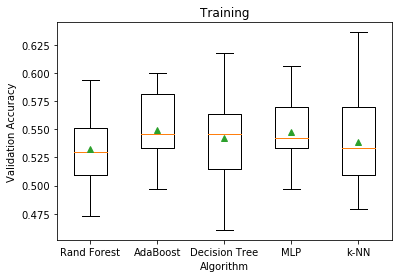

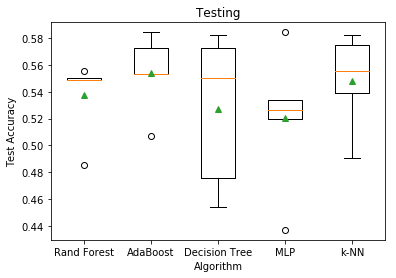

In [26]:
boxdata = [rf_val_scores, ab_val_scores, dt_val_scores, svm_val_scores, knn_val_scores]
labels = ['Rand Forest','AdaBoost','Decision Tree','MLP','k-NN']
plt.figure()
plt.boxplot(boxdata,labels=labels,showmeans=True)
plt.xlabel("Algorithm")
plt.ylabel("Validation Accuracy")
plt.title("Training")
plt.show()


boxdata = [rf_test_scores, ab_test_scores, dt_test_scores, svm_test_scores, knn_test_scores]
labels = ['Rand Forest','AdaBoost','Decision Tree','MLP','k-NN']
plt.figure()
plt.boxplot(boxdata,labels=labels,showmeans=True)
plt.xlabel("Algorithm")
plt.ylabel("Test Accuracy")
plt.title("Testing")
plt.show()